<a href="https://colab.research.google.com/github/hui509/Titanic_Survival_Prediction/blob/main/%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C%EF%BD%9C%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E5%AD%98%E6%B4%BB%E9%A0%90%E6%B8%AC%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **載入資料**

In [320]:
# 載入訓練集、測試集、示範檔資料
import pandas as pd
train_url = 'https://raw.githubusercontent.com/hui509/Titanic_Survival_Prediction/main/raw_data/train.csv'
test_url = 'https://raw.githubusercontent.com/hui509/Titanic_Survival_Prediction/main/raw_data/test.csv'
submit_url = 'https://raw.githubusercontent.com/hui509/Titanic_Survival_Prediction/main/raw_data/gender_submission.csv'

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)
submit = pd.read_csv(submit_url)

# **認識資料**

1. 訓練集｜891筆資料，12個欄位，包含Survival，其中，Age、Cabin、Embarked有缺失值。

2. 測試集｜418筆資料，11個欄位，缺少Survival，其中，Age、Fare、Cabin有缺失值。

In [ ]:
# 觀察訓練集
train.info()

In [ ]:
# 觀察測試集
test.info()

In [ ]:
# 訓練集缺失值統計
train.isnull().sum()

In [ ]:
# 測試集缺失值統計
test.isnull().sum()

# **合併訓練集與測試集**

In [325]:
# 合併訓練集、測試集，方便後續模型分析
data = train._append(test)
data.reset_index(inplace=True, drop=True)

# **資料探索與分析（EDA）**

1. 罹難者中，多屬於低票價的乘客。
2. Age 中，15歲以下的少年存活機率較高。
3. Sex 中，女性乘客的存活機會高於男性。
4. Pclass 中，一等艙的乘客有較高的存活機會。
5. Embarked 中，從 Cherbourg 登船者的存活機會較高。

<ipython-input-326-ed1e272e6ebe>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


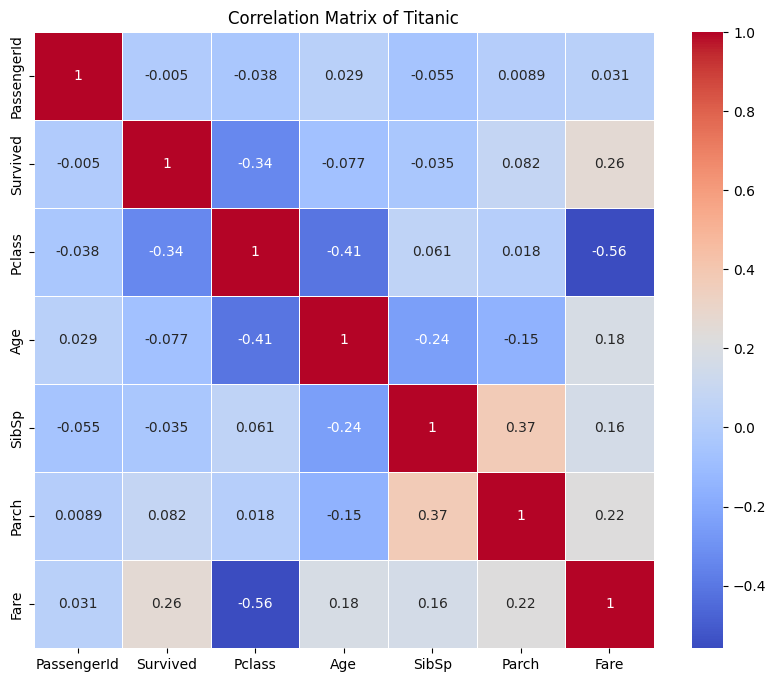

In [326]:
# 使用 Pearson 係數計算相關性
cor = data.corr()

# 使用seaborn和matplotlib，視覺化呈現相關性
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(cor,annot=True,linewidth=0.5,cmap='coolwarm')
plt.title('Correlation Matrix of Titanic')
plt.show()

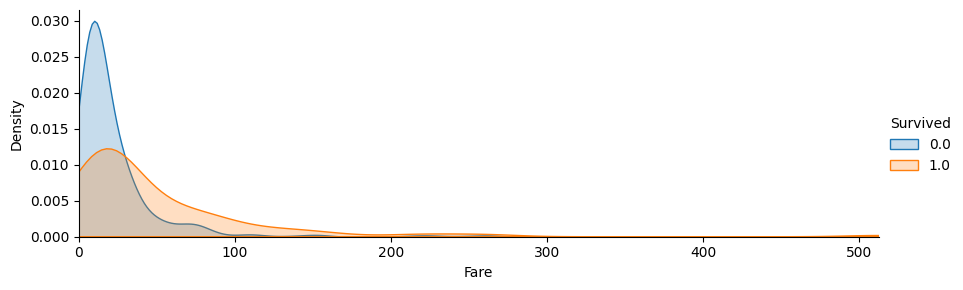

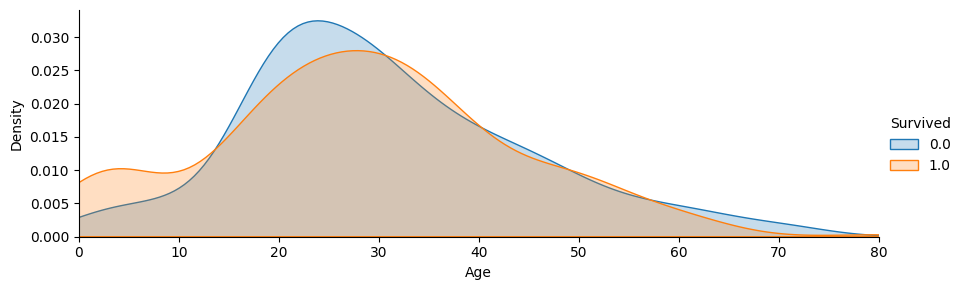

In [327]:
# 定義distribution函數，以KDE圖觀察欄位與Survived之間的關係

def distribution(data,var,target,**kwargs):
  # 設定row和col參數
  row = kwargs.get('row',None)
  col = kwargs.get('col',None)

  # 使用seaborn函數製圖
  facet = sns.FacetGrid(data,row=row,col=col,hue=target,aspect=3)
  facet.map(sns.kdeplot,var,fill=True)
  facet.set(xlim=(0,data[var].max()))
  facet.add_legend()

# 觀察Fare和Survived的關係
distribution(data,var='Fare',target='Survived')
plt.show()

# 觀察Age和Survived的關係
distribution(data,var='Age',target='Survived')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


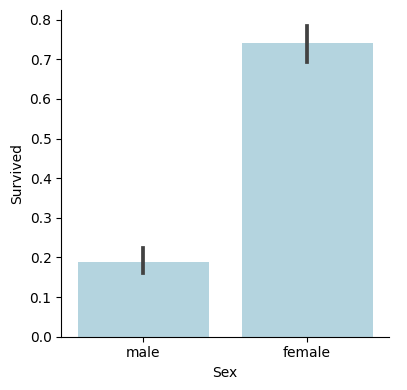

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


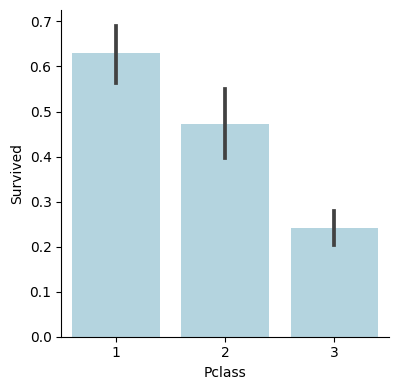

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


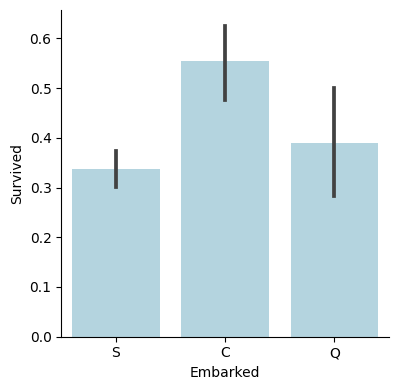

In [328]:
# 定義categories函數，以長條圖觀察欄位與Survived之間的關係

def categories(data,cat,target,**kwargs):
  # 設定row和col參數
  row = kwargs.get('row',None)
  col = kwargs.get('col',None)

  # 使用seaborn函數製圖
  facet = sns.FacetGrid(data,row=row,col=col,height=4)
  facet.map(sns.barplot,cat,target,color='lightblue')
  facet.add_legend()

# 觀察Sex和Survived的關係
categories(data,cat='Sex',target='Survived')
plt.show()

# 觀察Pclass和Survived的關係
categories(data,cat='Pclass',target='Survived')
plt.show()

# 觀察Embarked和Survived的關係
categories(data,cat='Embarked',target='Survived')
plt.show()

# **資料清理與型態轉換**

1. 缺失值｜Age、Fare 以平均數填補

2. 型態轉換｜Sex、Embarked







In [329]:
# Age 和 fare 為數值型態，以平均數填補
data['Age'].fillna(data['Age'].mean(),inplace=True)
data['Fare'].fillna(data['Fare'].mean(),inplace=True)

In [330]:
# 使用 OneHotEncoder 轉換 Embarked 為數值型態
data = pd.get_dummies(data,columns=['Embarked'],dtype=int)

In [331]:
# 將 Sex 轉換為數值型態
data['Sex'] = data['Sex'].replace({'male':1,'female':0})

In [332]:
# 刪除模型無法運算的欄位
data.drop(columns=['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

# **模型分析**

In [333]:
# 載入模型
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 產生訓練集和測試集
Train = data[ pd.notnull(data.Survived) ].copy()
Test = data[ pd.isnull(data.Survived) ].copy()

In [334]:
# X_Train 為訓練集的特徵欄位
# Y_Train 為訓練集的標籤欄位
X_Train = Train.drop( ['Survived'], axis=1 )
Y_Train = Train.Survived

# 測試集刪除 Survived 欄位
Test.drop( ['Survived'], axis=1, inplace=True )

In [335]:
# 使用Logistic Regression分析
model = LogisticRegression(random_state=0,max_iter=3000)
model.fit( X_Train, Y_Train )
scores = cross_val_score(model,X_Train,Y_Train.values.ravel(),cv=5,scoring='accuracy').mean()
print(scores)

0.789008850668508


In [ ]:
# 預測測試集的 Survived 結果
Test_pred = model.predict(Test)
print( Test_pred )

In [337]:
# 取得提交檔案
submit['Survived'] = Test_pred.astype(int)
submit.to_csv( 'Titanic_LogisticRegression_raw.csv', index=False )
print( f'預測結果：' )
print(submit)

預測結果：
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


In [ ]:
# 將提交檔案存入本機
from google.colab import files
files.download('Titanic_LogisticRegression_raw.csv')